## Functional Programming
* Spark is written in functional programming language Scala
* Application Programming Interface available in Java, R, Python
* In this course we'll using Python API (Pyspark) and we'll see the functional programming influence of Scala in Pyspark
E.g. let's look at the map reduce song count example

<img src="images/map_reduce.png">

This approach is different from Procedural Style as this is functional programming approach. In procedural style as shown below we use a counter and iterate through all the songs and increment when the song matches.

<img src="images/functional_procedural.png">

## Why use Functional Programming
* Perfect for distributed systems
* It has no side-effects on variables out of its scope
* It gets its name from functions in Algebra e.g
        f(x) = x + 5
        f(3) = 8
Here the output only depends on the input while in python functions the output depends not only on the input but also on the parameters e.g
        w = -1
        def f(x):
            global w
            w += 1
            return x + w+ 5
            
### QUIZ QUESTION
How is it possible that Spark programs can be written in Python if Python is not a functional programming language? Mark all answers that are true.
- [ ] You cannot write Spark Programs in Python
- [x] The Pyspark API is written with functional programming principles in mind.
- [ ] You can write Spark programs in Python using an API, but you need to be extra careful when writing Spark Programs with the Pyspark API because Python is an imperative language.
- [ ] Spark is written in Scala. So the PySpark API first translates your code to Scala, which is a functional programming language.

## Procedural Programming

The code in this section counts the number of times a song appears in the log_of_songs variable. 

You'll notice that the first time you run `count_plays("Despacito")`, you get the correct count. However, when you run the same code again `count_plays("Despacito")`, the results are no longer correct.This is because the global variable `play_count` stores the results outside of the count_plays function. 

In [1]:
log_of_songs = [
        "Despacito",
        "Nice for what",
        "No tears left to cry",
        "Despacito",
        "Havana",
        "In my feelings",
        "Nice for what",
        "Despacito",
        "All the stars"
]

In [2]:
play_count = 0

In [3]:
def count_plays(song_title):
    global play_count
    for song in log_of_songs:
        if song == song_title:
            play_count = play_count + 1
    return play_count

In [4]:
count_plays("Despacito")

3

In [5]:
count_plays("Despacito")

6

### How to Solve the Issue

How might you solve this issue? You could get rid of the global variable and instead use play_count as an input to the function:

```python
def count_plays(song_title, play_count):
    for song in log_of_songs:
        if song == song_title:
            play_count = play_count + 1
    return play_count

```

How would this work with parallel programming? Spark splits up data onto multiple machines. If your songs list were split onto two machines, Machine A would first need to finish counting, and then return its own result to Machine B. And then Machine B could use the output from Machine A and add to the count.

However, that isn't parallel computing. Machine B would have to wait until Machine A finishes. You'll see in the next parts of the lesson how Spark solves this issue with a functional programming paradigm.

In Spark, if your data is split onto two different machines, machine A will run a function to count how many times 'Despacito' appears on machine A. Machine B will simultaneously run a function to count how many times 'Despacito' appears on machine B. After they finish counting individually, they'll combine their results together. You'll see how this works in the next parts of the lesson.

## The Spark DAGs: Recipe for Data
Every spark function makes a copy of its input data and never changes the original parent data. As spark does not change the input data its called immutable. This makes sense when you have a single function but what happens when you have a lots of functions.After all there are a lot of steps when you wrangle data. In Spark we do that by chaining together multiple functions that each accomplish small amount of work. It seems that Spark would need to create a copy of the data for each sub-function but if this was the case the spark would run out of the memory. To avoid that Spark uses Lazy evaluation. Before Spark does anything on the data it first builds step by step  directions of which functions and data it'll need. These directions in Spark are called Directed Acyclic Graph (DAG for short). 

<img src="images/dag.png">

Once spark builds the DAG from the code it checks if it can procrastinate, waiting until the last possible moment to get the data.

Click [here](https://www.youtube.com/watch?v=lrgHpuIJxfM) for more explanation.

## Maps and Lambda Functions
### Maps

In Spark, maps take data as input and then transform that data with whatever function you put in the map. They are like directions for the data telling how each input should get to the output.

The first code cell creates a SparkContext object. With the SparkContext, you can input a dataset and parallelize the data across a cluster (since you are currently using Spark in local mode on a single machine, technically the dataset isn't distributed yet).

Run the code cell below to instantiate a SparkContext object and then read in the log_of_songs list into Spark. 

In [6]:
import pyspark
sc = pyspark.SparkContext(appName="maps_and_lazy_evaluation_example")

log_of_songs = [
        "Despacito",
        "Nice for what",
        "No tears left to cry",
        "Despacito",
        "Havana",
        "In my feelings",
        "Nice for what",
        "despacito",
        "All the stars"
]

# parallelize the log_of_songs to use with Spark
distributed_song_log = sc.parallelize(log_of_songs)

This next code cell defines a function that converts a song title to lowercase. Then there is an example converting the word "Havana" to "havana".

In [7]:
def convert_song_to_lowercase(song):
    return song.lower()

convert_song_to_lowercase("Havana")

'havana'

The following code cells demonstrate how to apply this function using a map step. The map step will go through each song in the list and apply the convert_song_to_lowercase() function. 

In [8]:
distributed_song_log.map(convert_song_to_lowercase)

PythonRDD[1] at RDD at PythonRDD.scala:53

You'll notice that this code cell ran quite quickly. This is because of lazy evaluation. Spark does not actually execute the map step unless it needs to.

"RDD" in the output refers to resilient distributed dataset. RDDs are exactly what they say they are: fault-tolerant datasets distributed across a cluster. This is how Spark stores data. 

To get Spark to actually run the map step, you need to use an "action". One available action is the collect method. The collect() method takes the results from all of the clusters and "collects" them into a single list on the master node.

In [9]:
distributed_song_log.map(convert_song_to_lowercase).collect()

['despacito',
 'nice for what',
 'no tears left to cry',
 'despacito',
 'havana',
 'in my feelings',
 'nice for what',
 'despacito',
 'all the stars']

Note as well that Spark is not changing the original data set: Spark is merely making a copy. You can see this by running collect() on the original dataset.

In [10]:
distributed_song_log.collect()

['Despacito',
 'Nice for what',
 'No tears left to cry',
 'Despacito',
 'Havana',
 'In my feelings',
 'Nice for what',
 'despacito',
 'All the stars']

You do not always have to write a custom function for the map step. You can also use anonymous (lambda) functions as well as built-in Python functions like string.lower(). 

Anonymous functions are actually a Python feature for writing functional style programs.

In [11]:
distributed_song_log.map(lambda song: song.lower()).collect()

['despacito',
 'nice for what',
 'no tears left to cry',
 'despacito',
 'havana',
 'in my feelings',
 'nice for what',
 'despacito',
 'all the stars']

## Data Formats
The most common data formats are:
* **CSV** - Comma Separated values(CSV) file stores tabula data in index format. Each line represents record where fields are in the same order defined usually by the first header. As the name suggests the records are separated by the `,`. This might be problematic if the records contain commas as well. So oftentimes the records are wrapped in quotes or alternative separators actualism.
* **JSON** - JavaScript Object Notation (JSON) store records in attribute value pairs. The values may contain simple often numeric types or arrays. JSON is very commonly used for browser server communication. So web server log files often contain this format.
* **HTML** - Hypertext Markup Language (HTML) is a standard markup language for creating web pages and we applications. If you scrape data from the Internet you will need to deal with HTML. Here we have tags like `<h1>` and values are enclosed between staring tag and ending tag. Following is an example of the tag and values:
        <h1> Header 1 </h1> 
* **XML** - Extensible Markup Language (XML) is generalized version of HTML where the tags don't have specific meaning. In XML you can define your own tags to encode the information in both a machine and human readable format. The difficulty in dealing with XML and HTML is that the elements can be nested.

## Distributed Data Stores
When we have so much data that we need distributed computing. The data itself needs to stored in a distributed way as well. Distributed files systems store the data in  a fault tolerant way. So if a machine breaks we don't lose the information.
In HDFS data is split in 128MB or 64 MB blocks and replicates this block across the cluster.
<img src="images/hdfs.png">

AWS uses S3 to store the raw data.

## SparkSession
The first component of each Spark Program is the the SparkContext. Spark context is the main entry point for the spark functionality and connects the cluster with the application.  

<img src="images/spark_context.png">

If we want to use lower level abstractions we'll create objects with SparkContext. Following is an example of the spark context:

In [1]:
from pyspark import SparkConf, SparkContext

# To create SparkContext we need to create sparkConf object first
configure = SparkConf().setAppName('name').setMaster('local')

sc = SparkContext(conf=configure)

To create dataframes we'll use SparkSession.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession\
            .builder\
            .appName('app name')\
            .config('spark.master','local')\
            .getOrCreate()

## Reading and Writing Data with Spark

This block contains the code from the previous screencast. The only difference is that instead of reading in a dataset from a remote cluster, the data set is read in from a local file. You can see the file by clicking on the "jupyter" icon and opening the folder titled "data".

Run the code cell to see how everything works. 

First let's import SparkConf and SparkSession

In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

Since we're using Spark locally we already have both a sparkcontext and a sparksession running. We can update some of the parameters, such our application's name. Let's just call it "Our first Python Spark SQL example"

In [2]:
spark = SparkSession \
    .builder \
    .appName("Our first Python Spark SQL example") \
    .getOrCreate()

Let's check if the change went through

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'Our first Python Spark SQL example'),
 ('spark.driver.host', 'LAPTOP-HLMKHI3J'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.driver.port', '50666'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1578032568411'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
spark

As you can see the app name is exactly how we set it

Let's create our first dataframe from a fairly small sample data set. Througout the course we'll work with a log file data set that describes user interactions with a music streaming service. The records describe events such as logging in to the site, visiting a page, listening to the next song, seeing an ad.

In [16]:
user_log = spark.read.json('data/sparkify_log_small.json')

In [17]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [18]:
user_log.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [19]:
user_log.show(n=1)

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------

In [10]:
user_log.take(5)

[Row(_corrupt_record=None, artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(_corrupt_record=None, artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(_corrupt_record=None, artist='Cob

In [20]:
out_path = "data/sparkify_log_small.csv"

In [21]:
user_log.write.save(out_path, format="csv", header=True)

In [22]:
user_log_2 = spark.read.csv(out_path, header=True)

In [23]:
user_log_2.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [24]:
user_log_2.take(2)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession='112', lastName='Matthews', length='232.93342', level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration='1509380319284', sessionId='5132', song='Christmas Tears Will Fall', status='200', ts='1513720872284', userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession='7', lastName='Chase', length='195.23873', level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration='1512718541284', sessionId='5027', song='Cheryl Tweedy', status='200', ts='1513720878284', userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000')]

In [25]:
user_log_2.select("userID").show()

+------+
|userID|
+------+
|  1046|
|  1000|
|  2219|
|  2373|
|  1747|
|  1747|
|  1162|
|  1061|
|   748|
|   597|
|  1806|
|   748|
|  1176|
|  2164|
|  2146|
|  2219|
|  1176|
|  2904|
|   597|
|   226|
+------+
only showing top 20 rows



## Imperative vs Declarative Programming
There are two ways to wrangle the data in Spark:

|Imperative Programming|Declarative Programming|
|----------------------|-----------------------|
|Spark DataFrames & Python| SQL|
|Cares about How|Cares about the 'What'|
|Example: drive to the car &rarr; go in the shop &rarr; buy the cake| Get the Cake
|We focus on the steps|We focus on the result we want to achieve|


## Data Wrangling with Data Frames

### Importing the libraries

In [27]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
import pyspark.sql.types as typ
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Creating Spark Session

In [28]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

### Reading the data

In [29]:
user_log = spark.read.json('data/sparkify_log_small.json')

### Displaying the first 10 rows

In [41]:
user_log.limit(10).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Showaddywaddy,Logged In,Kenneth,M,112,Matthews,232.93342,paid,"Charlotte-Concord-Gastonia, NC-SC",PUT,NextSong,1509380319284,5132,Christmas Tears Will Fall,200,1513720872284,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",1046
1,Lily Allen,Logged In,Elizabeth,F,7,Chase,195.23873,free,"Shreveport-Bossier City, LA",PUT,NextSong,1512718541284,5027,Cheryl Tweedy,200,1513720878284,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",1000
2,Cobra Starship Featuring Leighton Meester,Logged In,Vera,F,6,Blackwell,196.20526,paid,"Racine, WI",PUT,NextSong,1499855749284,5516,Good Girls Go Bad (Feat.Leighton Meester) (Alb...,200,1513720881284,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2219
3,Alex Smoke,Logged In,Sophee,F,8,Barker,405.99465,paid,"San Luis Obispo-Paso Robles-Arroyo Grande, CA",PUT,NextSong,1513009647284,2372,Don't See The Point,200,1513720905284,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2373
4,None,Logged In,Jordyn,F,0,Jones,NaN,free,"Syracuse, NY",GET,Home,1513648531284,1746,None,200,1513720913284,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1747


### Printing the schema

In [45]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Using summary on columns

In [46]:
user_log.describe('artist').toPandas()

,summary,artist
0,count,8348
1,mean,461.0
2,stddev,300.0
3,min,!!!
4,max,ÃÂlafur Arnalds


In [47]:
user_log.describe('sessionID').toPandas()

,summary,sessionID
0,count,10001
1,mean,4436.436356364364
2,stddev,2043.2684482891812
3,min,9
4,max,7144


### counts the number of rows

In [48]:
user_log.count() 

10001

### Get unique values in columns

In [50]:
user_log.select('page').drop_duplicates().sort('page').toPandas()

,page
0,About
1,Downgrade
2,Error
3,Help
4,Home
5,Login
6,Logout
7,NextSong
8,Save Settings
9,Settings


### Filtering

In [55]:
user_log.select(['userId','firstName','page','song']).where(user_log.userId == '1046').toPandas()

,userId,firstName,page,song
0,1046,Kenneth,NextSong,Christmas Tears Will Fall
1,1046,Kenneth,NextSong,Be Wary Of A Woman
2,1046,Kenneth,NextSong,Public Enemy No.1
3,1046,Kenneth,NextSong,Reign Of The Tyrants
4,1046,Kenneth,NextSong,Father And Son
5,1046,Kenneth,NextSong,No. 5
6,1046,Kenneth,NextSong,Seventeen
7,1046,Kenneth,Home,None
8,1046,Kenneth,NextSong,War on war
9,1046,Kenneth,NextSong,Killermont Street


### Grouping and datetime example

In [57]:
get_hour = fn.udf(lambda x:datetime.datetime.fromtimestamp(x/1000.0).hour)

In [58]:
user_log = user_log.withColumn('hour',get_hour(user_log.ts))

In [59]:
user_log.limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,hour
0,Showaddywaddy,Logged In,Kenneth,M,112,Matthews,232.93342,paid,"Charlotte-Concord-Gastonia, NC-SC",PUT,NextSong,1509380319284,5132,Christmas Tears Will Fall,200,1513720872284,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",1046,22
1,Lily Allen,Logged In,Elizabeth,F,7,Chase,195.23873,free,"Shreveport-Bossier City, LA",PUT,NextSong,1512718541284,5027,Cheryl Tweedy,200,1513720878284,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",1000,22
2,Cobra Starship Featuring Leighton Meester,Logged In,Vera,F,6,Blackwell,196.20526,paid,"Racine, WI",PUT,NextSong,1499855749284,5516,Good Girls Go Bad (Feat.Leighton Meester) (Alb...,200,1513720881284,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2219,22
3,Alex Smoke,Logged In,Sophee,F,8,Barker,405.99465,paid,"San Luis Obispo-Paso Robles-Arroyo Grande, CA",PUT,NextSong,1513009647284,2372,Don't See The Point,200,1513720905284,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2373,22
4,None,Logged In,Jordyn,F,0,Jones,NaN,free,"Syracuse, NY",GET,Home,1513648531284,1746,None,200,1513720913284,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1747,22
5,None,Logged In,Jordyn,F,1,Jones,NaN,free,"Syracuse, NY",GET,Settings,1513648531284,1746,None,200,1513720932284,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1747,22
6,Redman,Logged In,Paige,F,0,Hunter,154.53995,free,"Brownwood, TX",PUT,NextSong,1498414068284,4406,Smoke Buddah,200,1513720955284,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1162,22
7,Ulrich Schnauss,Logged In,Gabriel,M,2,Koch,402.93832,paid,"Panama City, FL",PUT,NextSong,1505820418284,1060,On My Own,200,1513720959284,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,1061,22
8,None,Logged In,Mason,M,2,Thomas,NaN,paid,"Indianapolis-Carmel-Anderson, IN",GET,Home,1487015656284,5661,None,200,1513720959284,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,748,22
9,None,Logged In,Alexander,M,0,Short,NaN,free,"Green Bay, WI",GET,Home,1513594398284,3689,None,200,1513720980284,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",597,22


In [64]:
songs_in_hour = user_log.filter(user_log.page == 'NextSong').groupby(user_log.hour).count().orderBy(user_log.hour.cast('float'))

In [65]:
songs_in_hour_pd = songs_in_hour.toPandas()

In [74]:
songs_in_hour_pd.hour = songs_in_hour_pd.hour.astype('int')

Text(0, 0.5, 'Songs played')

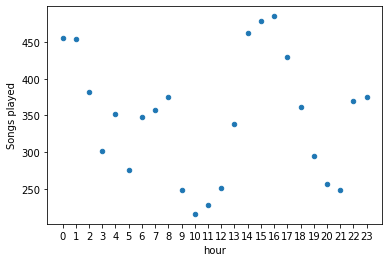

In [79]:
songs_in_hour_pd.plot('hour','count',kind='scatter',xticks=range(0,24))
plt.ylabel('Songs played')

### Missing values

In [80]:
user_log_valid = user_log.dropna(subset=['userId','sessionId'])

In [81]:
user_log_valid.count()

10001

In [82]:
user_log.select('userId').drop_duplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



As it can be seen that 1st entry is blank. let's apply the filter

In [83]:
user_log_valid = user_log_valid.filter(user_log_valid.userId !='')

In [84]:
user_log_valid.count()

9665

### Finding users who downgraded service